# 2-way Distal Admixture Tunisia Neolithic

In [4]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time

### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
# Make sure to have the font installed (it is on cluster for Harald)
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
os.sys.path.append(path)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

compute-e-16-229.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 28
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


### Do qpAdm Function Imports and Definitions

In [9]:
from python.run_qpadm import qpAdm_run, get_meta_ind_table, modifiy_iid_files, set_iids_to_label
from python.plot_qpadm import plot_qpadm, plot_qpadm_split

### Parameters for qpAdm_run are set there!
a12 = ["Mota", "Ust_Ishim", "Kostenki14", "GoyetQ116-1", "Vestonice16", "MA1",
           "ElMiron", "Villabruna", "EHG", "CHG", "Natufian",
           "Levant_N"] # List of ancient European populations for right populations

distal = ["Anatolia_N", "WHG", "Steppe_EMBA", 
          "Iran_N", "Morocco_EN.SG"]

print(f"# Anc_Euro: {len(a12)} populations")
print(f"# Distal sources: {len(distal)} populations")

# Anc_Euro: 12 populations
# Distal sources: 5 populations


# 1) Get Dataframe with anno clusters

In [5]:
vrs = "49.2"

df = get_meta_ind_table(path_ind = f"./eigenstrat/anc_only.v{vrs}_outgroups.ind",
                        path_anno = f"/n/groups/reich/hringbauer/Data/v{vrs}.anno.csv",
                        min_snp = 30000)

Filtering to 1137/1142
Loaded 1137 Individuals
Filtered to 1091 Individuals based on #SNP covered> 30000
Filtered to 1002 Individuals based on duplicates.


### 1b) Optional: Screen for population labels

In [12]:
df[df["clst"].str.contains("Morocco")]["clst"].value_counts()

Morocco_Iberomaurusian                   6
Morocco_LN.SG                            3
Morocco_EN.SG                            3
Morocco_unknown.SG                       1
Morocco_Iberomaurusian_sibling.TAF011    1
Name: clst, dtype: int64

### Prepare .ind File with Tunisia individuals seperated out

In [45]:
### Populations to overwrite. Typically because they have the ".SG" label
ind_merged = f"./eigenstrat/anc_only.v{vrs}_outgroups.ind"          # What .ind to load
ind_modified = f"./eigenstrat/anc_only.v{vrs}.tunisia_N_ind.ind"    # Where to save the modified version to
df_ind = pd.read_csv(ind_merged, delim_whitespace=True, header=None)
df_ind.columns=["iid", "sex", "clst"]
print(f"Loaded {len(df_ind)} Individuals")

modifiy_iid_files(df_ind, pops_overwrite=["Tunisia_EN", "Tunisia_N", "Tunisia_LN"], 
                  pops_overwrite12=[],
                  ind_modified = ind_modified)

Loaded 1142 Individuals
Found 1 Matches
Tunisia_EN    1
Name: clst, dtype: int64
Found 4 Matches
Tunisia_N    4
Name: clst, dtype: int64
Found 2 Matches
Tunisia_LN    2
Name: clst, dtype: int64
Saved 1142 Individuals to ./eigenstrat/anc_only.v49.2.tunisia_N_ind.ind


# Run distal Models for Tunisia

### Test Run for single Individual

In [21]:
%%time

target = "I20825"  
sources = distal
leftpops = [target] + sources
rightpops = a12

qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops) + ".log", 
          input_folder = "./eigenstrat/combined/", 
          input_file = "punic.v49.0",
          par_file_folder = "./parfiles/", 
          input_ind_suff = ".tunisia_N_ind", 
          output_folder = "./output/qpAdm/v49.0/area51/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=True)

Runtime: 96.386997
CPU times: user 5.56 ms, sys: 8.97 ms, total: 14.5 ms
Wall time: 1min 36s


0

## Run all single Indivdiuals

In [23]:
sources = distal
rightpops = a12

iids = df[df["clst"].str.contains("Tunisia_N")]["iid"].values
print(f"Found {len(iids)} Individuals to run...")

for target in iids:
    leftpops = [target] + sources
    qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
              output_file = ".".join(leftpops) + ".log", 
              input_folder = "./eigenstrat/combined/", 
              input_file = "punic.v49.0",
              par_file_folder = "./parfiles/", 
              input_ind_suff = ".tunisia_N_ind", 
              output_folder = "./output/qpAdm/v49.0/tunisia_n_distal/", 
              path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
              all_snps=True)

Found 8 Individuals to run...
Runtime: 99.077401
Runtime: 95.819268
Runtime: 95.919909
Runtime: 98.362426
Runtime: 119.191381
Runtime: 95.193831
Runtime: 95.467838
Runtime: 98.731012


# Run two way models for shift within Tunisia N:
Shift from Tunisia EN to Tunisia LN (only RC dates)

In [35]:
### Define Individuals that shifted
iids_old = ["I20824", "I20825", "I22580", "I22866"] # The four dated Individuals ("Tunisia Old")
iids_shift = ["I22852"] # The Hergla Individual ("Tunisia Shift")
path_merged = f"./eigenstrat/anc_only.v{vrs}_outgroups.ind"

df_ind = pd.read_csv(path_merged, delim_whitespace=True, header=None)
df_ind.columns=["iid", "sex", "clst"]
print(f"Loaded {len(df_ind)} Individuals")

set_iids_to_label(df_ind, iids_old, label_new="Tunisia_Old",
                    pops_overwrite12=[], savepath="")
set_iids_to_label(df_ind, iids_shift, label_new="Tunisia_Shift",
                    pops_overwrite12=[], savepath=f"./eigenstrat/anc_only.v{vrs}.tunisia_N_shft.ind")

# f"./eigenstrat/combined/punic.v{vrs}.tunisia_N_shft.ind"

Loaded 1142 Individuals
Overwriting 4 Individuals
Overwriting 1 Individuals
Saved 1142 Individuals to ./eigenstrat/anc_only.v49.2.tunisia_N_shft.ind


,iid,sex,clst
0,I1416,M,Levant_N
1,I4246_published,M,Spain_BellBeaker_oAfrica_published
2,I7182,M,Israel_MLBA
3,I7215,M,Italy_Sicily_Himera_480BCE_shackled
4,I7216,M,Italy_Sicily_Himera_480BCE_shackled
...,...,...,...
1137,I27619,F,Spain_Punic
1138,I26842.v47,F,Spain_Punic
1139,I26932.v47,M,Spain_Punic_Hypogeum
1140,I22103.v49.1,F,Spain_Vandals_possible_1d.rel.I23273


# Run qpAdm analysis for shift from Tunisia Old to Tunisia Shift

### Run a single Model

In [37]:
target = "Tunisia_Shift"  

s2s =  ["Spain_EN", "France_EN", "Israel_C", 'ElMiron', 'Villabruna', 
        'EHG','CHG', 'Natufian', 'Levant_N', "Italy_Sardinia_N", 
        "Anatolia_N", "Steppe_MLBA", "Iran_N", "Israel_MLBA", "Lebanon_MBA.SG"]

s2s = ["Egypt_ThirdIntermediatePeriod"]

for pop in s2s: #a12
    print(f"Running {pop}...")
    a12t = a12.copy()
    if pop in a12t:  ### Remove if needed
        a12t.remove(pop)

    sources = ["Tunisia_Old", pop] 

    leftpops = [target] + sources
    rightpops = a12t

    qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
              output_file = ".".join(leftpops) + "", 
              input_folder = "./eigenstrat/", 
              input_file = f"anc_only.v{vrs}", # punic.v{vrs}
              par_file_folder = "./parfiles/", 
              input_ind_suff = ".tunisia_N_shft", 
              output_folder = f"./output/qpAdm/v{vrs}/tun_n_shift/", 
              path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
              all_snps=True)

Running Israel_C...
Runtime: 53.060655


# Plot Results

Saved to ./figures/nafr/shift_tun_ln.pdf


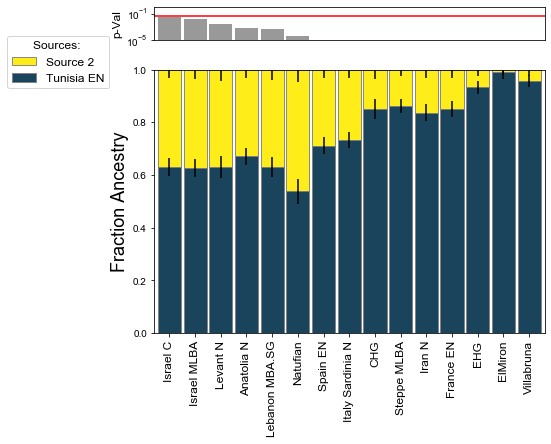

In [23]:
### Load the ancient Individual Label Data
vrs = "49.2"
s1 = "Tunisia_Old"
t = "Tunisia_Shift"

s2s =  ['ElMiron', 'Villabruna', 'EHG','CHG', 'Natufian', 'Levant_N', "Italy_Sardinia_N", 
        "Anatolia_N", "Steppe_MLBA", "Iran_N", "Israel_MLBA", "Lebanon_MBA.SG",
        "Spain_EN", "France_EN", "Israel_C" ]

#  "Egypt_ThirdIntermediatePeriod"]

paths = [".".join([t, s1, s2]) for s2 in s2s]

dir_path = f"./output/qpAdm/v{vrs}/tun_n_shift/"
save_path = "./figures/nafr/shift_tun_ln.pdf"
c = ["#003049", "#FFEC00"]

xlabels = [s.replace("_", " ") for s in s2s]
plot_qpadm(dir_path=dir_path, test_pops=paths, save_path=save_path,
           xlabels=xlabels, sort_p=True, labels=["Tunisia EN", "Source 2"],
           best=False, pval_lim = [1e-5,1], figsize=(7,6), bw=0.9, lw=1.5, 
           fs=12, c=c, ec="gray", l_pos=(-0.1, 1.15))

# Test Shift from Tunisia_HG -> Tunisia_EN

In [6]:
### Define Individuals that shifted
vrs = "49.2"
iids_old = ["I20824", "I20825"] # The two oldest dated Tunisiaindivdiuals, ca 6000 calBCE
iids_shift = ["I22580", "I22866"] # The two indivdiuals from Tunisia dated ca. 5000 calBCE
path_merged = f"./eigenstrat/anc_only.v{vrs}_outgroups.ind"

df_ind = pd.read_csv(path_merged, delim_whitespace=True, header=None)
df_ind.columns=["iid", "sex", "clst"]
print(f"Loaded {len(df_ind)} Individuals")

set_iids_to_label(df_ind, iids_old, label_new="Tunisia_Old",
                    pops_overwrite12=[], savepath="")
set_iids_to_label(df_ind, iids_shift, label_new="Tunisia_Shift",
                    pops_overwrite12=[], savepath=f"./eigenstrat/anc_only.v{vrs}.tunisia_N_shft1.ind");

Loaded 1142 Individuals
Overwriting 2 Individuals
Overwriting 2 Individuals
Saved 1142 Individuals to ./eigenstrat/anc_only.v49.2.tunisia_N_shft1.ind


In [41]:
%%time
target = "Tunisia_Shift"  

s2s =  ["Spain_EN", "France_EN", "Israel_C", 'ElMiron', 'Villabruna', 
        'EHG','CHG', 
        'Natufian', 'Levant_N', "Italy_Sardinia_N", 
        "Anatolia_N", "Iran_N", "Israel_MLBA", "Lebanon_MBA.SG"]
s2s = ["Egypt_ThirdIntermediatePeriod"]

for pop in s2s: #a12
    print(f"Running {pop}...")
    a12t = a12.copy()
    if pop in a12t:  ### Remove if needed
        a12t.remove(pop)

    sources = ["Tunisia_Old", pop] 

    leftpops = [target] + sources
    rightpops = a12t

    qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
              output_file = ".".join(leftpops) + "", 
              input_folder = "./eigenstrat/", 
              input_file = f"anc_only.v{vrs}",
              par_file_folder = "./parfiles/", 
              input_ind_suff = ".tunisia_N_shft1", 
              output_folder = f"./output/qpAdm/v{vrs}/tun_n_shift1/", 
              path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
              all_snps=True)

Running Egypt_ThirdIntermediatePeriod...
Runtime: 51.300653
CPU times: user 7.15 ms, sys: 6.22 ms, total: 13.4 ms
Wall time: 51.3 s


Saved to ./figures/nafr/shift_tun_n.pdf


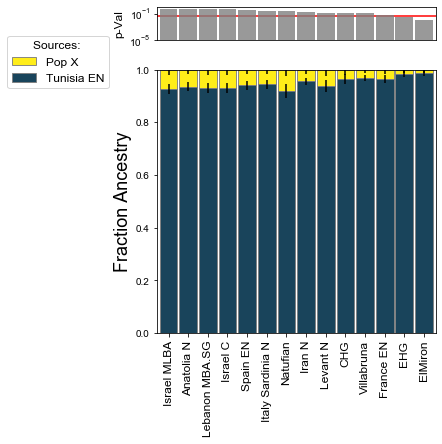

In [29]:
### Load the ancient Individual Label Data
vrs = "49.2"
s1 = "Tunisia_Old"
t = "Tunisia_Shift" 

s2s =  ["Spain_EN", "France_EN", "Israel_C", 'ElMiron', 'Villabruna', 
        'EHG','CHG', 'Natufian', 'Levant_N', "Italy_Sardinia_N", 
        "Anatolia_N", "Iran_N", "Israel_MLBA", "Lebanon_MBA.SG"]

# "Steppe_MLBA"
paths = [".".join([t, s1, s2]) for s2 in s2s]

dir_path = f"./output/qpAdm/v{vrs}/tun_n_shift1/"
save_path = "./figures/nafr/shift_tun_n.pdf" # ./figures/qpAdm/v44/4way_Canaanite.pdf
c = ["#003049", "#FFEC00"]

xlabels = [s.replace("_", " ") for s in s2s]
plot_qpadm(dir_path=dir_path, test_pops=paths, save_path=save_path,
           xlabels=xlabels, sort_p=True, labels=["Tunisia EN", "Pop X"],
           best=False, pval_lim = [1e-5,1], figsize=(5,6), bw=0.9, lw=1.5, 
           fs=12, c=c, ec="gray", l_pos=(-0.15, 1.15))

# Test the same for EN->LN Morocco Individuals

In [39]:
target = "Morocco_LN.SG"  

s2s =  ["Spain_EN", "France_EN", "Israel_C", 'ElMiron', 'Villabruna', 
        'EHG','CHG', 'Natufian', 'Levant_N', "Italy_Sardinia_N", 
        "Anatolia_N", "Steppe_MLBA", "Iran_N", "Israel_MLBA", "Lebanon_MBA.SG"]
s2s = ["Egypt_ThirdIntermediatePeriod"]

for pop in s2s: #a12
    print(f"Running {pop}...")
    a12t = a12.copy()
    if pop in a12t:  ### Remove if needed
        a12t.remove(pop)

    sources = ["Morocco_EN.SG", pop] 
    leftpops = [target] + sources
    rightpops = a12t

    qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
              output_file = ".".join(leftpops) + "", 
              input_folder = "./eigenstrat/", 
              input_file = f"anc_only.v{vrs}", # punic.v{vrs}
              par_file_folder = "./parfiles/", 
              input_ind_suff = ".tunisia_N_shft", 
              output_folder = f"./output/qpAdm/v{vrs}/mor_n_shift/", 
              path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
              all_snps=True)

Running Egypt_ThirdIntermediatePeriod...
Runtime: 52.238663


# Shift in Morocco EN -> LN from Europe

Saved to ./figures/nafr/shift_mor_en_ln.pdf


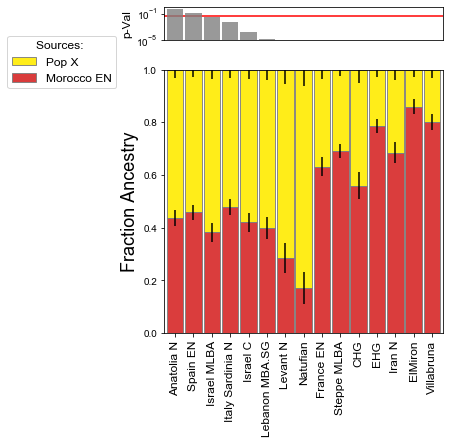

In [28]:
### Load the ancient Individual Label Data
s1 = "Morocco_EN.SG" 
t = "Morocco_LN.SG" 

s2s =  ['ElMiron', 'Villabruna', 'EHG','CHG', 'Natufian', 'Levant_N', "Italy_Sardinia_N", 
        "Anatolia_N", "Steppe_MLBA", "Iran_N", "Israel_MLBA", "Lebanon_MBA.SG",
        "Spain_EN", "France_EN", "Israel_C"] 

paths = [".".join([t, s1, s2]) for s2 in s2s]

dir_path = f"./output/qpAdm/v{vrs}/mor_n_shift/"
save_path = "./figures/nafr/shift_mor_en_ln.pdf" # ./figures/qpAdm/v44/4way_Canaanite.pdf
c = ["#d62828", "#FFEC00"]

xlabels = [s.replace("_", " ") for s in s2s]
plot_qpadm(dir_path=dir_path, test_pops=paths, save_path=save_path,
           xlabels=xlabels, sort_p=True, labels=["Morocco EN", "Pop X"],
           best=False, pval_lim = [1e-5,1], figsize=(5,6), bw=0.9, lw=1.5, 
           fs=12, c=c, ec="gray", l_pos=(-0.15, 1.15))

# Run Two Way model for all new Tunisian Samples
Model with Tunisia_Old sample + Israel C 

For each individual

In [47]:
### Define Individuals that shifted
iids_old = ["I20824", "I20825"] # The four dated Individuals ("Tunisia Old")
path_merged = f"./eigenstrat/anc_only.v{vrs}.tunisia_N_ind.ind"

df_ind = pd.read_csv(path_merged, delim_whitespace=True, header=None)
df_ind.columns=["iid", "sex", "clst"]
print(f"Loaded {len(df_ind)} Individuals")

set_iids_to_label(df_ind, iids_old, label_new="Tunisia_Old",
                    pops_overwrite12=[], savepath=f"./eigenstrat/anc_only.v{vrs}.tunisia_N_shft0.ind");

Loaded 1142 Individuals
Overwriting 2 Individuals
Saved 1142 Individuals to ./eigenstrat/anc_only.v49.2.tunisia_N_shft0.ind


In [49]:
%%time
sources = ["Tunisia_Old", "Israel_C"]  

ts = ["I22580", "I22866", "I22867",
      "I22862", "I22577", "I22852", "Algeria_IA"]

for t in ts: #a12
    print(f"Running {t}...")
    leftpops = [t] + sources
    rightpops = a12

    qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
              output_file = ".".join(leftpops) + "", 
              input_folder = "./eigenstrat/", 
              input_file = f"anc_only.v{vrs}",
              par_file_folder = "./parfiles/", 
              input_ind_suff = ".tunisia_N_shft0", 
              output_folder = f"./output/qpAdm/v{vrs}/tun_n_shift0/", 
              path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
              all_snps=True)

Running I22580...
Runtime: 50.035768
Running I22866...
Runtime: 51.744694
Running I22867...
Runtime: 53.373607
Running I22862...
Runtime: 48.913909
Running I22577...
Runtime: 48.757362
Running I22852...
Runtime: 50.291023
Running Algeria_IA...
Runtime: 50.602915
CPU times: user 30.3 ms, sys: 50.8 ms, total: 81.1 ms
Wall time: 5min 53s


Saved to ./figures/nafr/qpadm_shift_ind.pdf


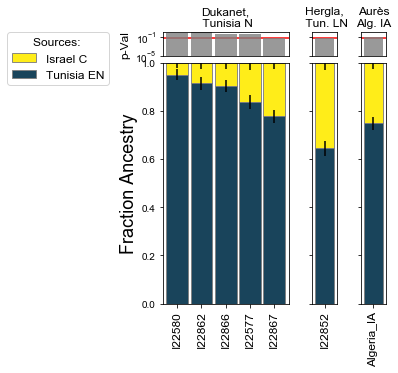

In [21]:
### Load the ancient Individual Label Data
s1 = "Tunisia_Old" 
s2= "Israel_C" 

sites = ["Dukanet,\n Tunisia N", "Hergla,\n Tun. LN", "Aurès\nAlg. IA"]
ls = [["I22580", "I22862", "I22866", "I22577", "I22867"], ["I22852"], ["Algeria_IA"]]
paths = [[".".join([t, s1, s2]) for t in ts] for ts in ls]

dir_path = f"./output/qpAdm/v{vrs}/tun_n_shift0/"
save_path = "./figures/nafr/qpadm_shift_ind.pdf" # ./figures/qpAdm/v44/4way_Canaanite.pdf
c = ["#003049", "#FFEC00"]
labels = ["Tunisia EN", "Israel C"]

plot_qpadm_split(dir_path=dir_path, test_pops=paths, save_path=save_path,
           labels_source=labels, labels_site=sites,
           best=True, pval_lim = [1e-5,1], figsize=(4,5), bw=0.9, lw=1.5, wspace=0.4,
           fs=12, c=c, ec="gray", l_pos=(-0.38, 1.15))

# Tunisia_Old and Morocco_Iberomaurusian 1 way model (with no African Outpgroup other than Mota)
p-value ~0.01!!

In [9]:
a12

['Mota',
 'Ust_Ishim',
 'Kostenki14',
 'GoyetQ116-1',
 'Vestonice16',
 'MA1',
 'ElMiron',
 'Villabruna',
 'EHG',
 'CHG',
 'Natufian',
 'Levant_N']

In [46]:
%%time

target = "Tunisia_Old" 
sources = ["Morocco_Iberomaurusian"]
leftpops = [target] + sources
rightpops = a12

qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops),
          input_folder = "./eigenstrat/combined/", 
          input_file = f"punic.v{vrs}",
          par_file_folder = "./parfiles/", 
          input_ind_suff = ".tunisia_N_shft", 
          output_folder = f"./output/qpAdm/v{vrs}/area51/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=True)

Runtime: 54.686758
CPU times: user 5.54 ms, sys: 6.55 ms, total: 12.1 ms
Wall time: 54.7 s


0

# Tunisia LN and Morocco LN not cladal!
p-Value: 1.11957036e-05

In [48]:
%%time

target = "Tunisia_Shift" 
sources = ["Morocco_LN.SG"]
leftpops = [target] + sources
rightpops = a12

qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops),
          input_folder = "./eigenstrat/combined/", 
          input_file = f"punic.v{vrs}",
          par_file_folder = "./parfiles/", 
          input_ind_suff = ".tunisia_N_shft", 
          output_folder = f"./output/qpAdm/v{vrs}/area51/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=True)

Runtime: 54.577098
CPU times: user 6.28 ms, sys: 7.3 ms, total: 13.6 ms
Wall time: 54.6 s


0

# Do pw. qpAdm Plots

In [10]:
### Define Individuals that shifted
vrs = "49.2"
iids_old = ["I20824", "I20825"] # The two oldest dated Tunisiaindivdiuals, ca 6000 calBCE
iids_shift = ["I22580", "I22866"] # The two indivdiuals from Tunisia dated ca. 5000 calBCE
iids_late = ["I22852"]

path_merged = f"./eigenstrat/anc_only.v{vrs}_outgroups.ind"

df_ind = pd.read_csv(path_merged, delim_whitespace=True, header=None)
df_ind.columns=["iid", "sex", "clst"]
print(f"Loaded {len(df_ind)} Individuals")

set_iids_to_label(df_ind, iids_old, label_new="Tunisia_HG",
                    pops_overwrite12=[], savepath="")
set_iids_to_label(df_ind, iids_shift, label_new="Tunisia_EN",
                    pops_overwrite12=[], savepath="")
set_iids_to_label(df_ind, iids_late, label_new="Tunisia_LN",
                    pops_overwrite12=[], savepath=f"./eigenstrat/anc_only.v{vrs}.tunisia_N_shft2.ind");

Loaded 1142 Individuals
Overwriting 2 Individuals
Overwriting 2 Individuals
Overwriting 1 Individuals
Saved 1142 Individuals to ./eigenstrat/anc_only.v49.2.tunisia_N_shft2.ind


### Test shifts from M. Iberomarusian to early African groups

In [16]:
rightpops = a12 #+ ["Iran_N"]
leftpops = ["Morocco_Iberomaurusian", "Morocco_EN.SG"]

qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops), 
          input_folder = "./eigenstrat/", 
          input_file = "anc_only.v49.2",
          input_ind_suff = ".tunisia_N_shft2",
          par_file_folder = "./parfiles/", 
          output_folder = "./output/qpAdm/v49.2/iberom_continuity/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=False)

Runtime: 47.860780


0

In [17]:
rightpops = a12 #+ ["Iran_N"]
leftpops = ["Morocco_Iberomaurusian", "Tunisia_HG"]

qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops), 
          input_folder = "./eigenstrat/", 
          input_file = "anc_only.v49.2",
          input_ind_suff = ".tunisia_N_shft2",
          par_file_folder = "./parfiles/", 
          output_folder = "./output/qpAdm/v49.2/iberom_continuity/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=False)

Runtime: 45.664495


0

In [18]:
rightpops = a12 #+ ["Iran_N"]
leftpops = ["Morocco_EN.SG", "Tunisia_HG"]

qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops), 
          input_folder = "./eigenstrat/", 
          input_file = "anc_only.v49.2",
          input_ind_suff = ".tunisia_N_shft2",
          par_file_folder = "./parfiles/", 
          output_folder = "./output/qpAdm/v49.2/iberom_continuity/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=False)

Runtime: 45.438778


0

In [19]:
rightpops = a12 + ["Morocco_Iberomaurusian"]
leftpops = ["Morocco_EN.SG", "Tunisia_HG"]

qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops), 
          input_folder = "./eigenstrat/", 
          input_file = "anc_only.v49.2",
          input_ind_suff = ".tunisia_N_shft2",
          par_file_folder = "./parfiles/", 
          output_folder = "./output/qpAdm/v49.2/iberom_continuity/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=False)

Runtime: 46.362433


0

## Run all Nord Afr. Pairs of post-Iberomaurusian

In [21]:
pop_list = ["Morocco_EN.SG", "Morocco_LN.SG", "Tunisia_HG", 
            "Tunisia_EN", "Tunisia_LN", "Algeria_IA"]

for p in it.combinations(pop_list, r=2):  ### One run was with r=1
    rightpops = a12 + ["Morocco_Iberomaurusian"]
    leftpops = list(p)
    
    qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
              output_file = ".".join(leftpops), 
              input_folder = "./eigenstrat/", 
              input_file = "anc_only.v49.2",
              input_ind_suff = ".tunisia_N_shft2",
              par_file_folder = "./parfiles/", 
              output_folder = "./output/qpAdm/v49.2/nafr_2way/", 
              path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
              all_snps=False)

Runtime: 50.610288
Runtime: 48.676206
Runtime: 49.447104
Runtime: 50.187104
Runtime: 48.874556
Runtime: 50.733334
Runtime: 50.703132
Runtime: 50.334632
Runtime: 51.191803
Runtime: 50.724256
Runtime: 48.258289
Runtime: 49.642784
Runtime: 51.326303
Runtime: 47.932543
Runtime: 48.036009


In [2]:
df_nafr = pd.read_csv("./data/plot_nafr.v51.1.tsv", sep="\t")

In [ ]:
df_nafr

# Area 51

In [24]:
df[df["clst"].str.contains("Egypt")]#["iid"].values

,iid,sex_x,clst,Master ID,loc,n_cov_snp,avg_cov_snp,sex_y
539,JK2911,M,Egypt_ThirdIntermediatePeriod,JK2911,Abusir-el Meleq,505080.0,0.880832,M
612,I4502,M,Egypt_Roman_oGreek,I4502,Giza,402820.0,0.511,M
626,I3339_all,M,Egypt_Hellenistic_Roman_all,I3339,Thebes,387029.0,0.439,M
679,I3440_all,M,Egypt_Roman_all,I3440,"Abydos, Arabat-el-Matfoon",318559.0,0.355,M
718,I4281_all,F,Egypt_Dynastic_Nubian_all,I4281,Thebes,256226.0,0.268545,F
732,I4270_all,M,Egypt_Dynastic_all,I4270,Deshasheh,235639.0,0.241,M
831,JK2134,M,Egypt_ThirdIntermediatePeriod,JK2134,Abusir-el Meleq,127235.0,0.117729,M
885,I3438_all,F,Egypt_Hellenistic_all,I3438,"Memphis, Saccara, Necropolis, Pyramid of Five-...",89030.0,0.082,F
890,I5958,M,Egypt_Roman,I5958,..,86706.0,0.077,M


In [ ]:
I22852